In [1]:
import matplotlib.pyplot as plt
import torch
import zuko

from tqdm.notebook import tqdm
from zuko.mixtures import GMM

In [2]:
def sample_gaussians(context):
    means = torch.tensor(
        [[-7.0, 0.0], [0.0, 0.0], [7.0, 0.0]]
    ).unsqueeze(0)

    means = means.repeat(context.shape[0], 1, 1)

    means[..., 0, 0] += context
    means[..., 2, 0] -= context

    covs = torch.tensor(
        [
            [[2.2, 0.0], [0.0, 2.2]],
            [[2.0, 0.0], [0.0, 1.0]],
            [[1.8, 0.8], [0.8, 0.8]],
        ]
    ).unsqueeze(0)

    covs = covs.repeat(means.shape[0], 1, 1, 1)
    covs[..., 0, 0] += 0.1 * context.unsqueeze(-1)
    covs[..., 1, 1] -= 0.1 * context.unsqueeze(-1)

    true_dist = zuko.distributions.Mixture(
        torch.distributions.MultivariateNormal(means, covs),
        torch.tensor([1.0, 1.0, 1.0])
    )

    return true_dist

def get_samples(n_samples, context_range):
    context = (context_range[1] - context_range[0]) * torch.rand(n_samples) + context_range[0]
    return sample_gaussians(context).sample()

# Example usage:
context_range = (-2, 2)

torch.Size([10000, 3, 2])


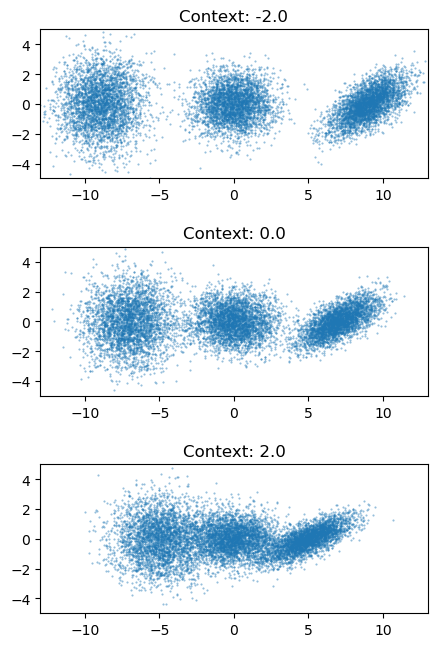

In [3]:
context_min = torch.tensor(context_range[0])
context_mean = torch.tensor(context_range[0] + 0.5 * (context_range[1] - context_range[0]))
context_max = torch.tensor(context_range[1])

contexts = torch.tensor([context_min, context_mean, context_max])

samples = sample_gaussians(contexts).sample((10000,))

print(samples.shape)

fig, axs = plt.subplots(3, 1, figsize=(5, 8))

for i, (ax, ctx) in enumerate(zip(axs, contexts)):
    ax.scatter(samples[:, i, 0], samples[:, i, 1], alpha=0.5, s=1, marker='.')
    ax.set_xlim(-13, 13)
    ax.set_ylim(-5, 5)
    ax.set_aspect('equal')
    ax.set_title(f'Context: {ctx.item()}')

plt.show()

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
torch.manual_seed(0)

lr = 1e-3
components=3

scenarios = [
    ['full', False],
    ['full', True],
    # ['lowrank', False, 2],
    # ['lowrank', True, 2],
    ['diag', False],
    ['diag', True],
    ['spherical', False],
    ['spherical', True],
]

gmm_list = [GMM(
    features=2,
    context=1,
    components=components,
    covariance_type=scenario[0],
    tied=scenario[1],
    # cov_rank=scenario[2] if len(scenario) > 2 else None
    ) for scenario in scenarios]

optimizer_list = [torch.optim.Adam(gmm.parameters(), lr=lr) for gmm in gmm_list]
losses_list = [[] for _ in gmm_list]

for i, gmm in enumerate(gmm_list):
    gmm.initialize(
        get_samples(1024, context_range),
        # strategy="kmeans++",
        strategy='kmeans',
        # strategy='random',
        )

    # for key, value in gmm.named_parameters():
    #     print(key, value.data) 

# for gmm in gmm_list:
#     gmm.phi[1].data = means.clone()
#     print(gmm.phi[1].data)

for i in tqdm(range(200)):
    for gmm, optimizer, losses in zip(gmm_list, optimizer_list, losses_list):

        optimizer.zero_grad()

        context_samples = (context_max - context_min) * torch.rand(128) + context_min
        samples = sample_gaussians(context_samples).sample()

        loss = -gmm(context_samples.unsqueeze(-1)).log_prob(samples).mean()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())


  0%|          | 0/200 [00:00<?, ?it/s]

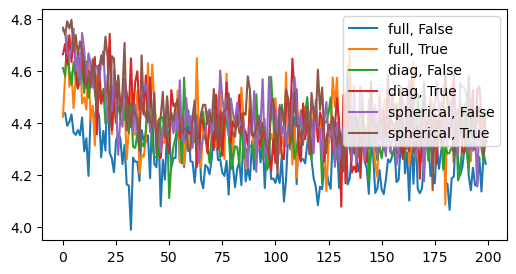

In [6]:
fig, ax = plt.subplots(figsize=(6, 3))

for i, losses in enumerate(losses_list):
    ax.plot(losses, label=f'{scenarios[i][0]}, {scenarios[i][1]}')

plt.legend()
plt.show()

In [7]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [8]:
# print numeber of free parameters for each model

for gmm, scenario in zip(gmm_list, scenarios):
    print(f'{scenario}: {get_n_params(gmm)}')

['full', False]: 5458
['full', True]: 5068
['diag', False]: 5263
['diag', True]: 5003
['spherical', False]: 5068
['spherical', True]: 4938


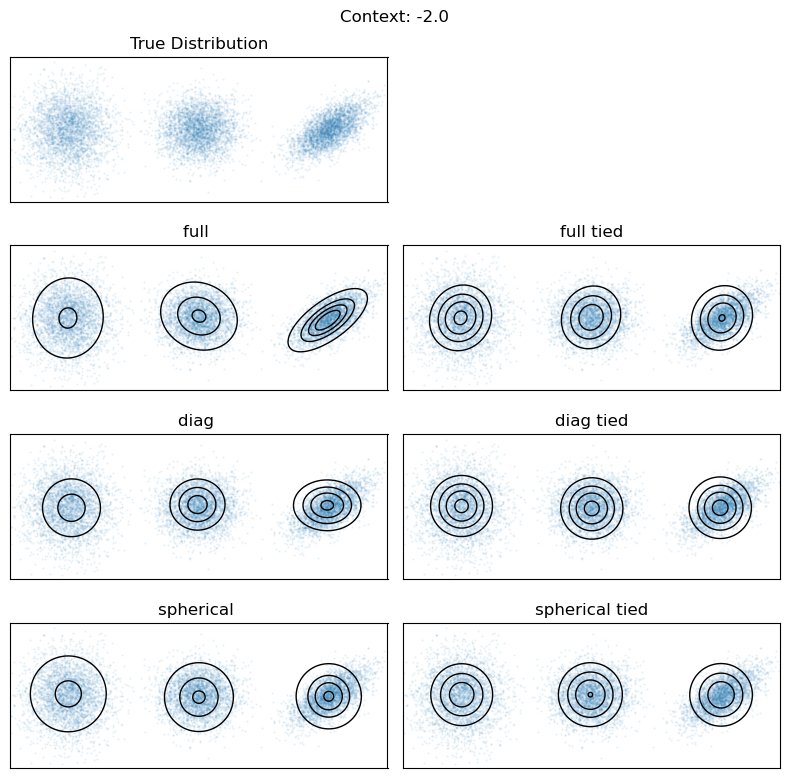

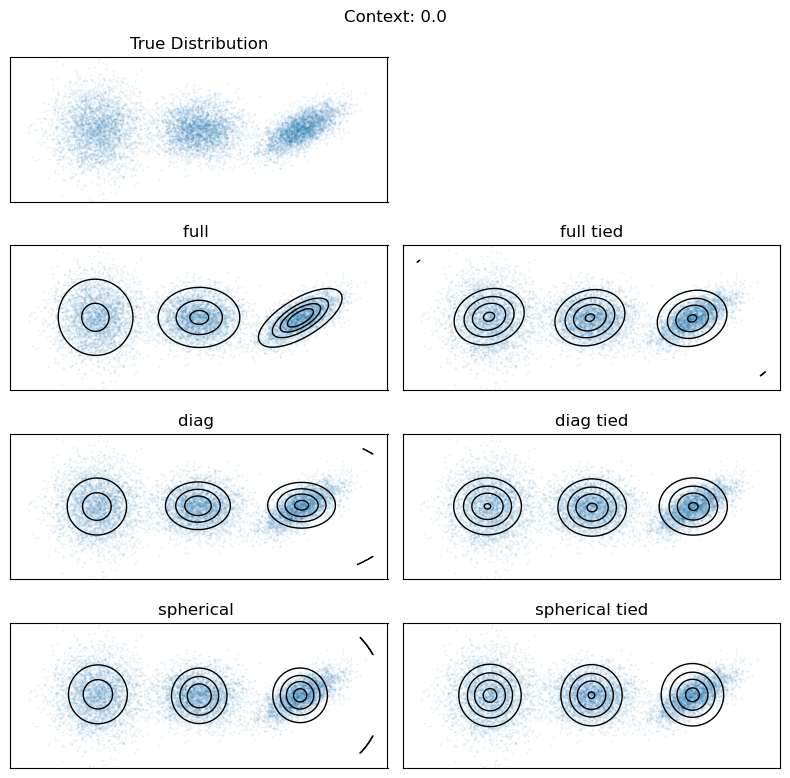

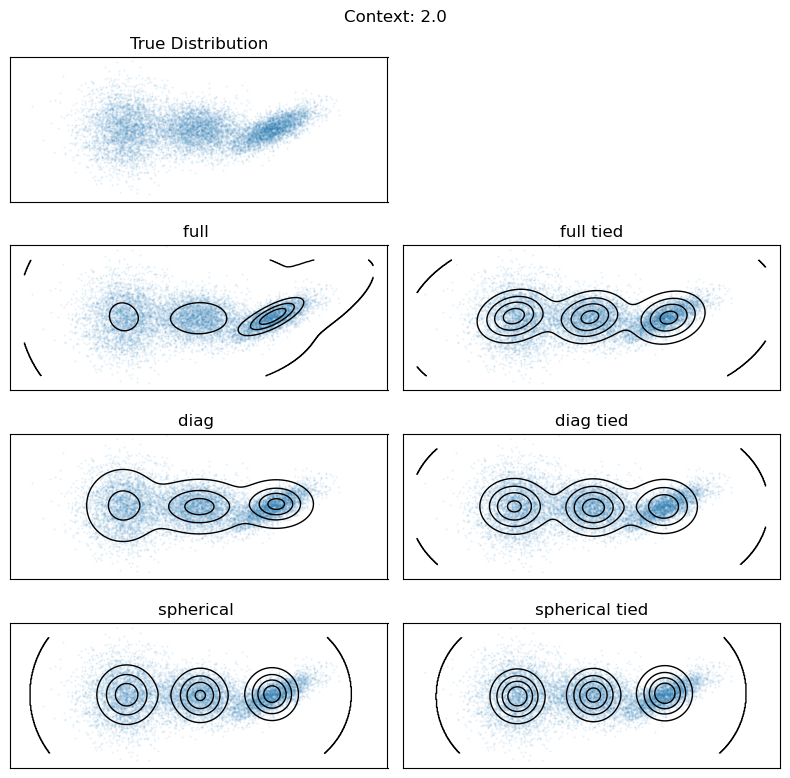

In [9]:
# plot each in thei own axis
levels = 4

x = torch.linspace(-12.0, 12.0, 500)
y = torch.linspace(-4.0, 4.0, 500)

X, Y = torch.meshgrid(x, y, indexing="ij")
Z = torch.stack([X, Y], dim=-1).reshape(-1, 2)

context_list = [-2.0, 0.0, 2.0]

for context in context_list:

    fig, axs = plt.subplots(len(gmm_list)//2+1, 2, figsize=(8, 8))

    axs = axs.flatten()

    context = torch.tensor(context).unsqueeze(0)
    prior_samples = sample_gaussians(context).sample((10000,)).squeeze(1)

    axs[0].scatter(prior_samples[:, 0], prior_samples[:,  1], alpha=0.1, s=1, marker='.')

    axs[0].title.set_text('True Distribution')

    #merge first two axes
    axs[1].remove()

    for ax, gmm in zip(axs[2:], gmm_list):

        ax.scatter(prior_samples[:, 0], prior_samples[:, 1], alpha=0.1, s=1, marker='.')

        logprob = gmm(context).log_prob(Z).exp().reshape(500, 500).detach()
        ax.contour(
            X, Y, logprob.exp(), levels=levels, colors='black', linewidths=1)
        ax.title.set_text(f'{gmm.covariance_type} {"tied" if gmm.tied else ""}')

    for ax in axs:
        ax.set_aspect('equal')
        ax.set_xlim(-13, 13)
        ax.set_ylim(-5, 5)

        ax.set_xticks([])
        ax.set_yticks([])

    fig.suptitle(f'Context: {context.item()}')

    plt.tight_layout()
    plt.show()